<a href="https://colab.research.google.com/github/Thandriss/DL_labs/blob/main/Act_Crit_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install gym
!pip install pyglet

In [81]:
%%bash
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [82]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple



env = gym.make("CartPole-v0")


seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


eps = np.finfo(np.float32).eps.item()

In [83]:
class ActorCritic(tf.keras.Model):


  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="softmax")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [84]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

In [85]:


def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [86]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):

    state = tf.expand_dims(state, 0)
  

    action_logits_t, value = model(state)
  

    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)


    values = values.write(t, tf.squeeze(value))


    action_probs = action_probs.write(t, action_probs_t[0, action])
  

    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  

    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

In [87]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:


  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)


  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

In [88]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:


  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [89]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:


  with tf.GradientTape() as tape:


    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 


    returns = get_expected_return(rewards, gamma)


    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 


    loss = compute_loss(action_probs, values, returns)


  grads = tape.gradient(loss, model.trainable_variables)


  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

In [90]:
%%time

min_episodes_criterion = 100
max_episodes = 10
max_steps_per_episode = 1000


reward_threshold = 195
running_reward = 0


gamma = 0.99


episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  

    if i % 10 == 0:
      pass 
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 9: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s, episode_reward=23, running_reward=24.6]


Solved at episode 9: average reward: 24.60!
CPU times: user 3.41 s, sys: 62.3 ms, total: 3.47 s
Wall time: 4.36 s


In [91]:


from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)


    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images



images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'

images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


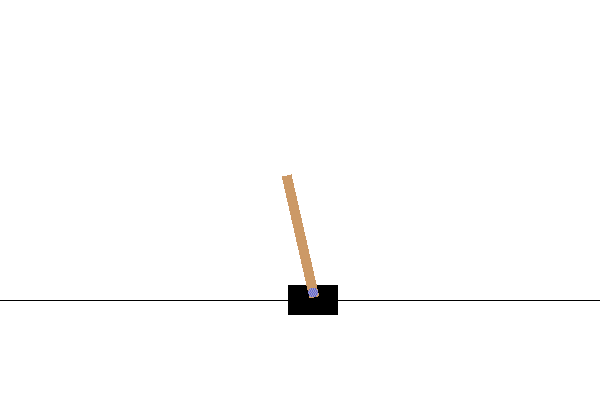

In [92]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)